In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

# import sys
# sys.path.insert(0, r'/Users/Student/OneDrive/MSci project/MSci2022_TESS/packages')
# from unit_conversion import *

In [2]:
def semi_major_axis_in_stellar_radii(semi_major_axis, R_star):
    """
    Converting the semi-major axis (AU) to (Stellar radii)

    Parameters
    ----------
    semi_major_axis : float
        Semi-major axis of the planet in AU.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    a_stellar_radii : float
        Semi-major axis of the planet in stellar radii.
    """
    #1 AU = 215.032 R_Sun

    a_stellar_radii = semi_major_axis * 215.032 / R_star

    return a_stellar_radii

In [3]:
TIC = 'TIC 66818296' #WASP-17 / TIC 66818296

search_result = lk.search_lightcurve(
    target=TIC,
    mission='TESS', author='SPOC')
print("trying to download")
lc_collection = search_result.download_all()
print("Search done")
print(lc_collection)
lc = lc_collection.stitch(corrector_func=lambda x: x.
                          remove_nans().normalize(unit='unscaled'))
#Sector 12 and sector 
# lc = lc.remove_outliers(sigma=10)
lc = lc.remove_nans()
lc = lc.normalize()

trying to download
Search done
LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 66818296" SECTOR=12 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 66818296" SECTOR=38 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [4]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1628.9527366213874,9.9146342e-01,2.2294226e-03,5.7549695e-03,289074,1734.75869,254.41609,5.6552012e+03,1.2536695e+01,4.5658228e+03,5.9796586e+00,6.3341509e+03,1.4243086e+01,0,———,———,———,———,1734.75869,1.7931858e-03,254.41609,1.7716236e-03,4.0939126e-02,2.0365320e-01
1628.9541255101508,9.9583793e-01,2.2304894e-03,5.7549700e-03,289075,1734.74578,254.42646,5.6748306e+03,1.2542694e+01,4.5680073e+03,5.9771156e+00,6.3620981e+03,1.4249902e+01,0,———,———,———,———,1734.74578,1.7894373e-03,254.42646,1.7657484e-03,2.5400141e-02,2.1769401e-01
1628.955514398915,9.9091458e-01,2.2287809e-03,5.7549705e-03,289076,1734.75697,254.42326,5.6416396e+03,1.2533087e+01,4.5655005e+03,5.9784079e+00,6.3306445e+03,1.4238987e+01,0,———,———,———,———,1734.75697,1.8040523e-03,254.42326,1.7733830e-03,3.9708838e-02,2.1558438e-01
1628.9569032876798,9.9025726e-01,2.2276556e-03,5.7549709e-03,289077,1734.77388,254.40724,5.6449824e+03,1.2526758e+01,4.5653208e+03,5.9806061e+00,6.3264453e+03,1.4231798e+01,0,———,———,———,———,1734.77388,1.8003181e-03,254.40724,1.7727494e-03,5.3074531e-02,1.9718842e-01
1628.9582921764436,9.9405742e-01,2.2288344e-03,5.7549714e-03,289078,1734.75465,254.41574,5.6675269e+03,1.2533387e+01,4.5580649e+03,5.9763598e+00,6.3507231e+03,1.4239328e+01,0,———,———,———,———,1734.75465,1.7944344e-03,254.41574,1.7658967e-03,4.2726278e-02,2.0543911e-01
1628.959681065207,9.9572426e-01,2.2284959e-03,5.7549719e-03,289079,1734.73932,254.42526,5.6712891e+03,1.2531484e+01,4.5560479e+03,5.9750943e+00,6.3613721e+03,1.4237165e+01,0,———,———,———,———,1734.73932,1.7894540e-03,254.42526,1.7633970e-03,2.1659279e-02,2.1886539e-01
1628.961069953971,9.9142510e-01,2.2267138e-03,5.7549723e-03,289080,1734.75758,254.41773,5.6525649e+03,1.2521463e+01,4.5581753e+03,5.9713359e+00,6.3339062e+03,1.4225781e+01,0,———,———,———,———,1734.75758,1.7970275e-03,254.41773,1.7686322e-03,3.9847802e-02,2.0756216e-01
1628.962458842735,9.9342662e-01,2.2281376e-03,5.7549728e-03,289081,1734.75298,254.41704,5.6614937e+03,1.2529469e+01,4.5481836e+03,5.9697313e+00,6.3466934e+03,1.4234877e+01,0,———,———,———,———,1734.75298,1.7935706e-03,254.41704,1.7688903e-03,3.7096344e-02,2.0781381e-01


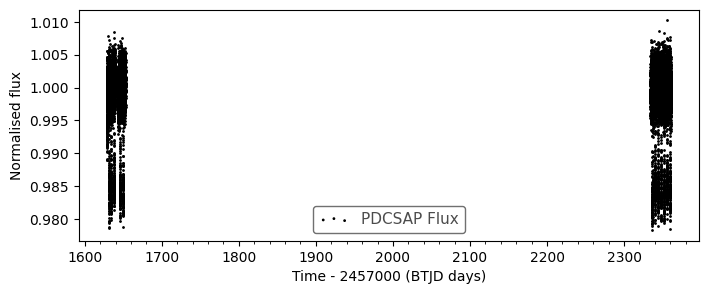

In [5]:
fig, axs = plt.subplots(1, figsize=(8, 3))
yes = lc.scatter(label='PDCSAP Flux', ax=axs, normalize=True, ylabel="Normalised flux", color='black')

axs.set_xlabel("Time - 2457000 (BTJD days)")

axs.xaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()

In [6]:
# lc_f = lc.flatten()
# lc_bin = lc_f.bin(time_bin_size = 0.006944444) # Default time is in days
# lc_bin = lc_bin.remove_nans()
# #0.006944444 day = 10 minutes

t = np.array(lc.time.btjd)
flux_data = np.array(lc.flux)
yerrs = np.array(lc.flux_err)

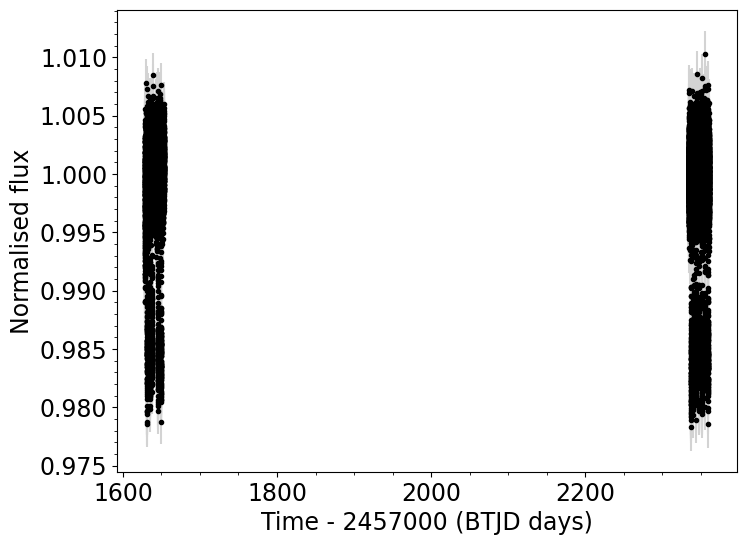

In [7]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.errorbar(t, flux_data, yerrs, fmt='.', color='Black', ecolor='LightGrey')


plt.ylabel("Normalised flux", size=17)
plt.xlabel("Time - 2457000 (BTJD days)", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()


In [8]:
#System
#http://exoplanets.org/detail/WASP-17b

# Semi-Major Axis[au]	0.04994 ± 0.00083
# Orbital Period[day]	3.7354330 +7.5×10-6/-7.7×10-6
# Orbital Eccentricity	0
# Orbit Inclination[deg]	86.63 +0.39/-0.45
# Argument of Periastron[deg]	90

# Time of Periastron[jd]	2454559.18096 +0.00025/-0.00021
# Transit Parameters
# Planetary Radius[rjupiter]	1.93 +0.052/-0.1
# Impact Parameter	0.400 +0.043/-0.04

# Stellar Properties
# Star Name	WASP-17
# Binary Flag	✗
# Mass of Star[msun]	1.190 ± 0.03
# Radius of Star[rsun]	1.200 +0.081/-0.08
# [Fe/H]	-0.250 ± 0.09
# Teff[k]	6550 ± 100
# Density of star[g/cm^3]	0.67 +0.16/-0.13
# log10(g)	4.20 ± 0.2
# Vsin(i)[km/s]	9.0 ± 1.5
# Gamma[km/s]	-49

In [9]:
prior_Rs = 1.583 #R_sun Southworth et al. 2012

guess_params = batman.TransitParams()
guess_params.ecc = 0.0                                         #eccentricity
guess_params.w = 90.                                          #longitude of periastron (in degrees)
guess_params.limb_dark = "quadratic"                          #limb darkening model
guess_params.u = [0.21768792859790628, 0.2836292883489928]                             #limb darkening coefficients [u1, u2, u3, u4]


In [10]:
def log_likelihood(prior_params, true_flux, yerrs):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    t_0, R_planet_stellar, orbital_period, orbital_inclination, semi_major_axis = prior_params

    guess_params.t0 = t_0
    guess_params.rp = R_planet_stellar
    guess_params.per = orbital_period
    guess_params.inc = orbital_inclination
    guess_params.a = semi_major_axis_in_stellar_radii(semi_major_axis, prior_Rs)
    
    
    guess_m = batman.TransitModel(guess_params, t)
    guess_flux = guess_m.light_curve(guess_params)
    # print("guess_flux ", guess_flux)
        
    L1 = -0.5 * np.power((true_flux - guess_flux), 2) / np.power(yerrs, 2) #Sigma
    # print("L1 ", L1)
    L2 = -0.5 * np.log(2 * np.pi * yerrs**2) #Sigma
    # print("L2 ", L2)
    L3 = np.sum(L1) + np.sum(L2)
    return L3


def log_prior(prior_params):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    t_0, R_planet_stellar, orbital_period, orbital_inclination, semi_major_axis = prior_params

    P = 0.0
    if (t_0 < 1630.5) or (t_0 > 1631.5): #Days
        P += -np.inf
        return -np.inf

    if (R_planet_stellar < 0) or (R_planet_stellar > 0.2):
        P += -np.inf
        return P

    if (orbital_period < 3.73538) or (orbital_period > 3.73556): #Days
        P += -np.inf
        return P

    if (orbital_inclination < 81) or (orbital_inclination > 90): #Degrees
        P += -np.inf
        return -np.inf
    

    if (semi_major_axis < 0) or (semi_major_axis > 0.07): #AU
        P += -np.inf
        return P

    return P

def log_prob(prior_params, true_flux, yerrs):
    lp = log_prior(prior_params)
    if (np.isinf(lp) == True):
        return -np.inf

    return log_likelihood(prior_params, true_flux, yerrs) + lp

In [11]:
prior_t0 = 1630.9 #(Days) Myself
prior_rprs = 0.1255 #Southworth et al. 2012
prior_per = 3.73548546 #(Days) Alderson et al. 2022
prior_inc = 86.71 #(Deg) Southworth et al. 2012
prior_a = 0.05151 #(AU) Bonomo et al. 2017

guess = [prior_t0, prior_rprs, prior_per, prior_inc, prior_a]

In [12]:
scatter = [1E-4, 1E-4, 1E-8, 1E-1, 1E-4] #Walker scattering of the parameters

pos = guess + scatter * np.random.randn(20, len(guess))

nwalkers, ndim = pos.shape

filename = "wasp_17b_sector12_and_sector38.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool() as pool:
    start_time = time.time()
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(flux_data, yerrs), a=2)
    sampler.run_mcmc(pos, 10000, progress=True)
    end_time = time.time()
    execution_time = (end_time - start_time)
    print("Start:       {}".format(time.ctime(int(start_time))))
    print("End:         {}".format(time.ctime(int(end_time))))
    print("Time taken:  {:.2f} s".format(execution_time))

100%|██████████| 10000/10000 [14:50<00:00, 11.23it/s]


Start:       Tue Jan 24 14:27:00 2023
End:         Tue Jan 24 14:41:50 2023
Time taken:  890.76 s


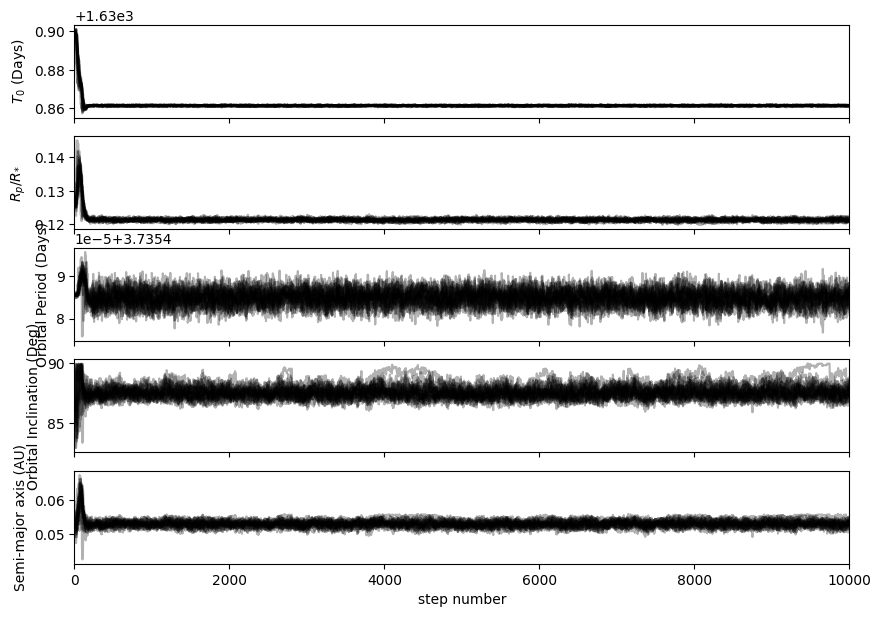

In [13]:
fig, axes = plt.subplots(len(guess), figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
guess = [prior_t0, prior_rprs, prior_per, prior_inc, prior_a]
labels = [r"$T_{0}$ (Days)", r"$R_{p}/R_{*}$", "Orbital Period (Days)", "Orbital Inclination (Deg)", "Semi-major axis (AU)", ]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [14]:
tau = sampler.get_autocorr_time()
print(tau)

[ 79.42361302 114.66605119  64.79063919 126.45656349 100.27913326]


In [15]:
# burnin = int(2 * np.max(tau))
# thin = int(0.5 * np.min(tau))
# flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
print(flat_samples.shape)

(13060, 5)


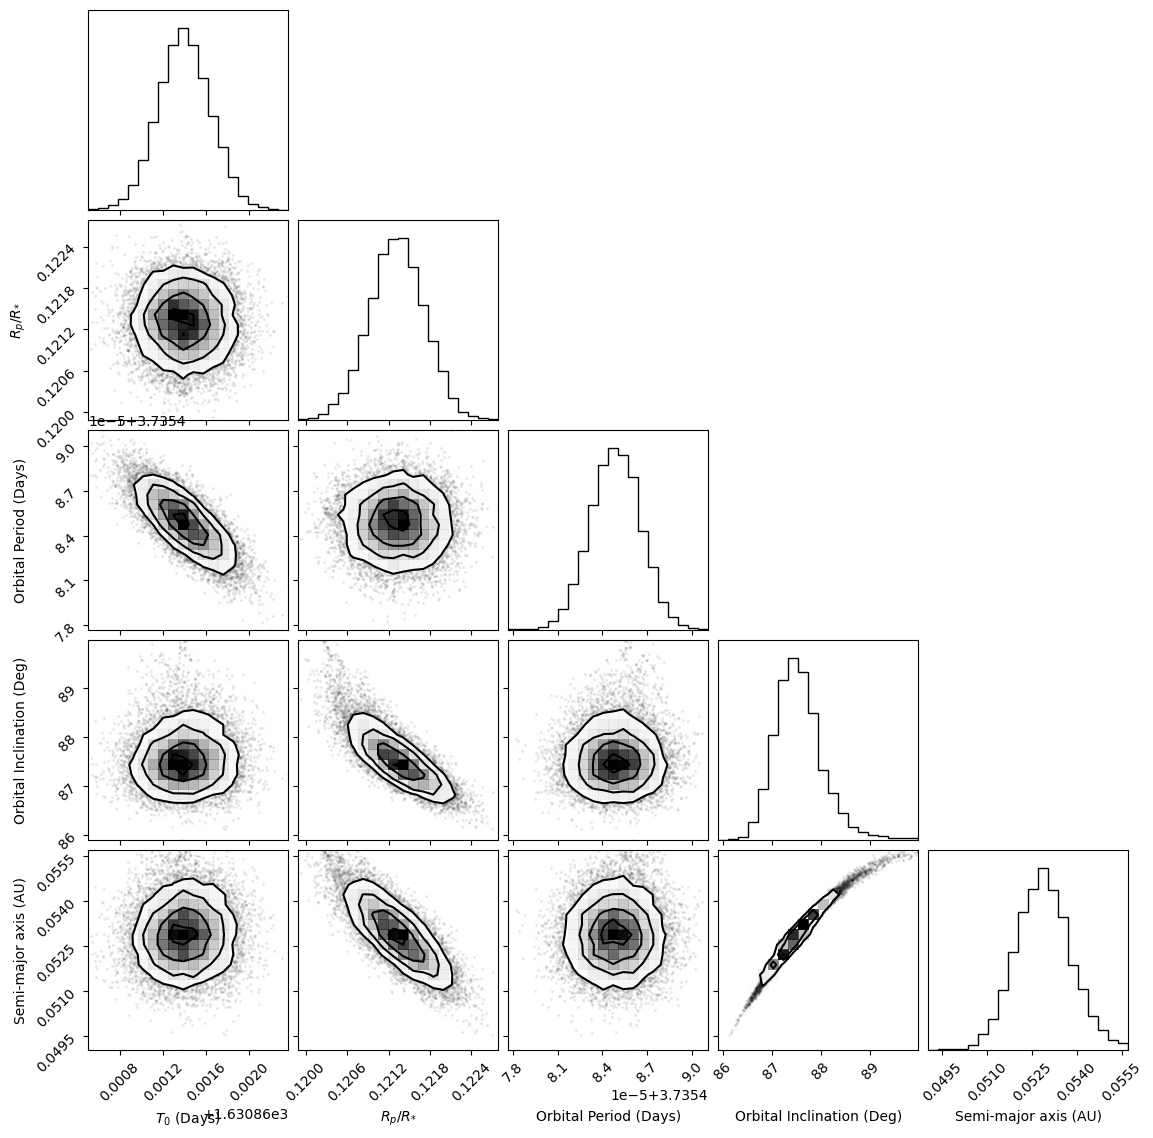

In [16]:
fig = corner.corner(
    flat_samples, labels=labels)

In [17]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.8f}_{{-{1:.10f}}}^{{{2:.10f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [18]:
model_T0 = np.percentile(flat_samples[:, 0], 50)
model_Rp = np.percentile(flat_samples[:, 1], 50)
model_per = np.percentile(flat_samples[:, 2], 50)
model_inc = np.percentile(flat_samples[:, 3], 50)
model_a = np.percentile(flat_samples[:, 4], 50)


model_params = batman.TransitParams()
model_params.t0 = model_T0                                          #time of inferior conjunction
model_params.per = model_per                                        #orbital period (days)
model_params.rp = model_Rp                #planet radius (in units of stellar radii)
model_params.a = semi_major_axis_in_stellar_radii(model_a, prior_Rs) #semi-major axis (in units of stellar radii))
model_params.inc = model_inc                                     #orbital inclination (in degrees)
model_params.ecc = 0.0                                         #eccentricity
model_params.w = 90.                                          #longitude of periastron (in degrees)
model_params.limb_dark = "quadratic"                          #limb darkening model
model_params.u = guess_params.u                           #limb darkening coefficients [u1, u2, u3, u4]

m = batman.TransitModel(model_params, t)                      #initializes model
model_flux = m.light_curve(model_params)

In [19]:
residual = flux_data - model_flux

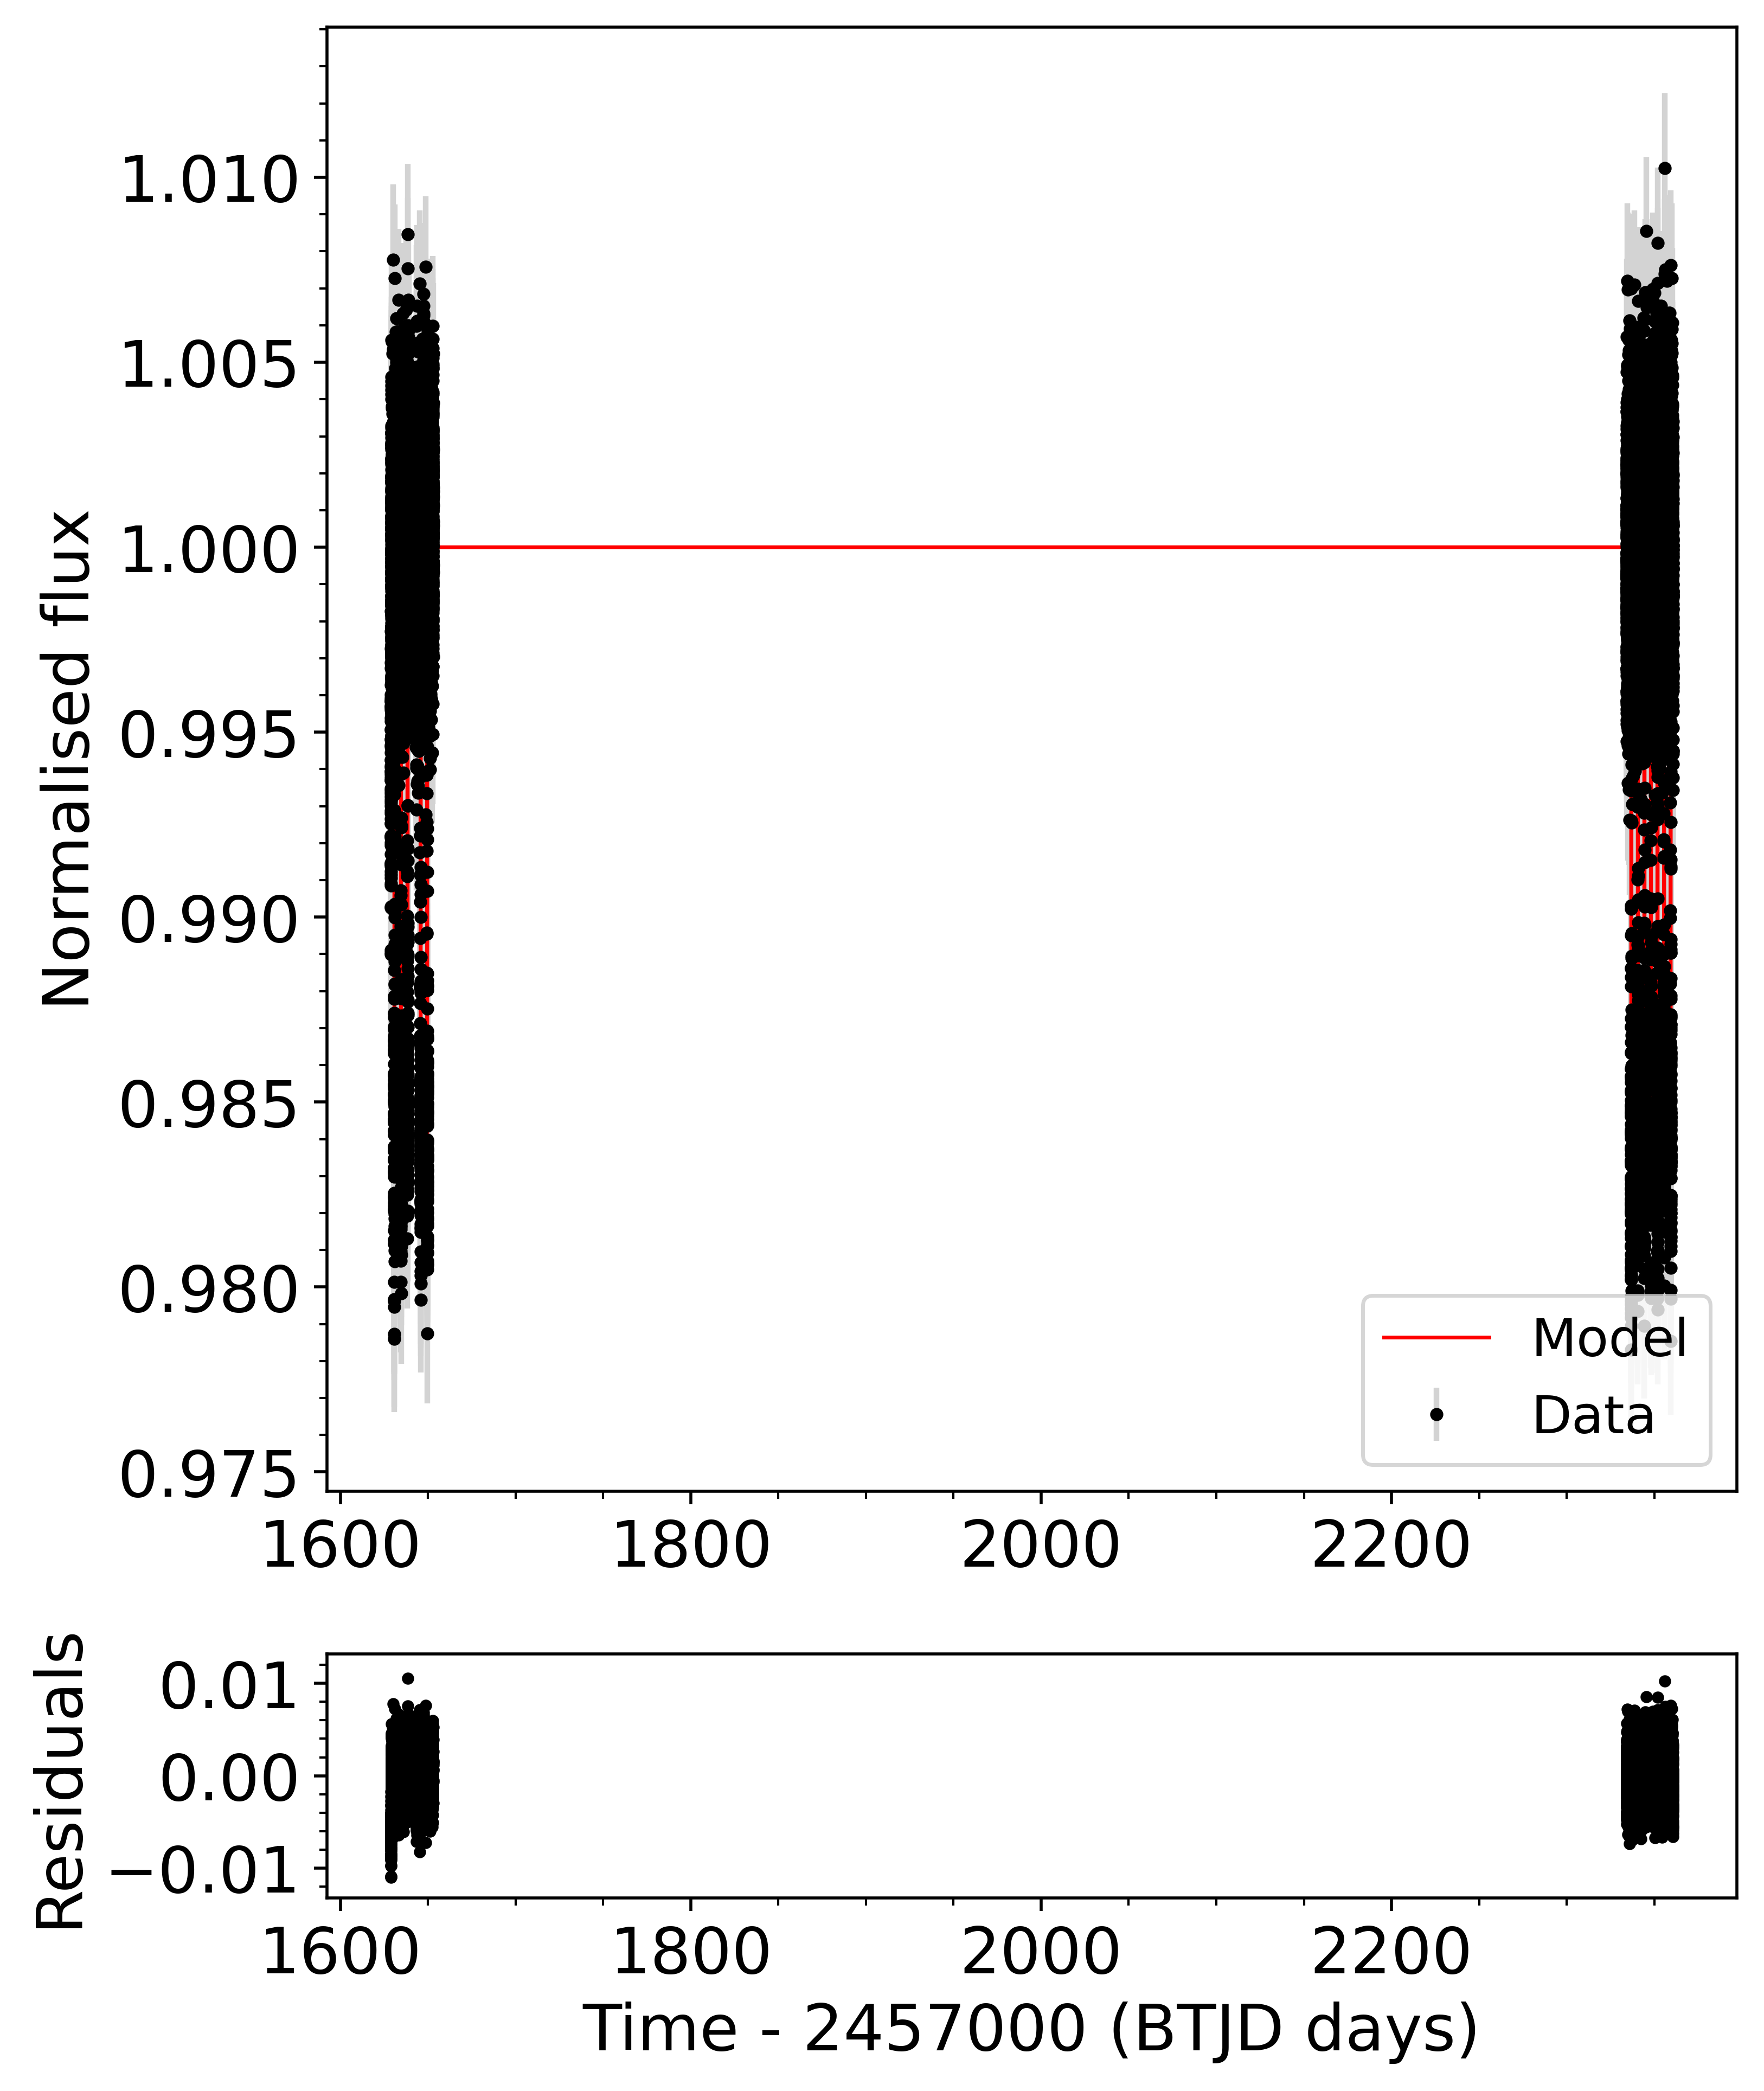

In [20]:
#Panel settings
left = 0.1
bottom = 0.1
width = 0.65
height = 0.9
spacing = -1.15

rect = [left, bottom, width, height]
rect_res = [left, bottom+height+spacing, width, 0.15]

fig = plt.figure(figsize=(8, 6), dpi=500)
ax = fig.add_axes(rect)

ax_res = fig.add_axes(rect_res, sharex=ax)

#Top panel
ax.errorbar(t, flux_data, yerr=yerrs, fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data")
ax.plot(t, model_flux, color='red',label="Model", lw=1)

ax.set(ylabel="Normalised flux")
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)

ax.legend(prop={'size': 14}, loc="lower right")

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

#Bottom panel
ax_res.scatter(t, residual, color='black', s=5)
ax_res.set_ylim((-max(abs(residual))*1.2, max(abs(residual)*1.2)))
# ax_res.plot([min(t), max(t)], [0, 0], color='red', lw=1)

ax_res.set(xlabel="Time - 2457000 (BTJD days)", ylabel="Residuals")
ax_res.xaxis.label.set_size(17)
ax_res.yaxis.label.set_size(17)

ax_res.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax_res.xaxis.set_tick_params(labelsize=17)
ax_res.yaxis.set_tick_params(labelsize=17)

# fig.subplots_adjust(hspace=0.1)
plt.show()